In [1]:
# bIBLIOTECAS
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from xgboost import XGBRegressor

In [2]:
df = pd.read_excel(r"C:\Users\alexa\OneDrive\Área de Trabalho\repositorios_git\DNC_repository\series_temporais\base_arima_energy.xlsx", index_col="DATE", parse_dates=True)
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [3]:
# Descrição dos dados
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


In [4]:
# Separando base de treino e validação
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((384, 1), (24, 1))

In [5]:
df.columns = ['producao']

In [6]:
# Análise minímo e máximo do índice de treino
treino.index.min(), treino.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [7]:
# Análise minímo e máximo do índice da validacao
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

<AxesSubplot:xlabel='DATE'>

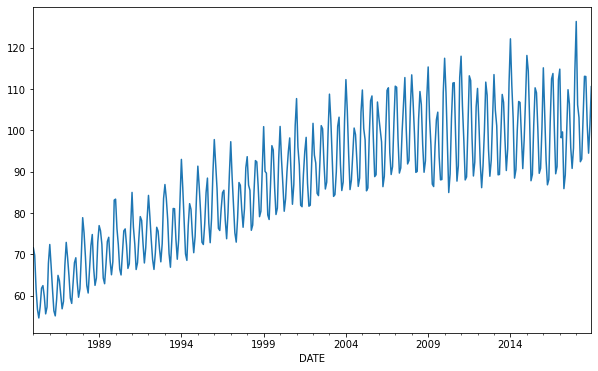

In [8]:
# Plotando o gráfico da base
df['producao'].plot(figsize=(10,6))

<Figure size 576x360 with 0 Axes>

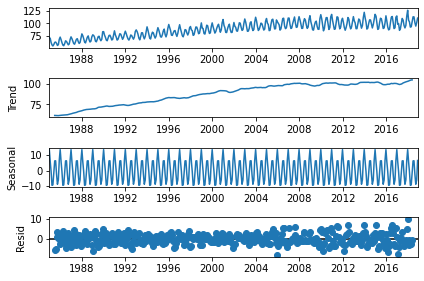

In [9]:
# Decomposição para análise de sazonalidade
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8,5))
fig = resultado.plot()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
# Como o p valor foi de 18%, a série provavelmente não é estacionária
result = adfuller(df['producao'].dropna())
print(f'Teste ADF: {result[0]}')
print(f'Tp valor: {result[1]}')

Teste ADF: -2.252399047046608
Tp valor: 0.18777984601967346


In [12]:
# O diff foi acrescentado para comparar o dia atual com o anterior
# para verificar se com essa variável podemos concluir se a série é estacion´pnaria
# podemos rejeitar a hipotese nula, a série é estacionário, pois  o p valor deu menor que 5%
result = adfuller(df['producao'].diff().dropna())
print(f'Teste ADF: {result[0]}')
print(f'Tp valor: {result[1]}')

Teste ADF: -7.450892277526375
Tp valor: 5.674569955854434e-11


In [13]:
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p = 3, max_q=3,
                       seasonal=True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=2,
                       information_criterion='aic',
                       trace=True,
                       error_action="ignore",
                       stepwise=True)

"""
O método auto_arima da biblioteca pmdarima é utilizado para automatizar o processo de ajuste de um modelo 
ARIMA (AutoRegressive Integrated Moving Average) ou SARIMA (Seasonal ARIMA) em séries temporais. 
Aqui está uma explicação dos parâmetros usados no seu código:

df: O dataframe que contém a série temporal que você está tentando ajustar.
d=1: O número de diferenciações necessárias para tornar a série temporal estacionária (parte não sazonal).
start_p=1: O valor inicial para o parâmetro p (ordem do componente auto-regressivo).
start_q=1: O valor inicial para o parâmetro q (ordem do componente de média móvel).
max_p=3: O valor máximo que p pode assumir durante a busca.
max_q=3: O valor máximo que q pode assumir durante a busca.
seasonal=True: Indica se o modelo deve considerar sazonalidade.
m=6: A periodicidade da sazonalidade (por exemplo, se os dados têm uma sazonalidade mensal e a frequência é anual, então m=12).
D=1: O número de diferenciações sazonais necessárias para tornar a série temporal estacionária.
start_P=1: O valor inicial para o parâmetro sazonal P (ordem do componente auto-regressivo sazonal).
start_Q=2: O valor inicial para o parâmetro sazonal Q (ordem do componente de média móvel sazonal).
information_criterion='aic': O critério de informação usado para selecionar o melhor modelo (AIC - Critério de Informação de Akaike).
trace=True: Mostra o progresso da busca pelo melhor modelo, imprimindo informações no console.
error_action="ignore": Ignora os erros durante a busca por parâmetros, continuando a execução.
stepwise=True: Executa uma busca iterativa para encontrar os melhores parâmetros (em vez de testar todas as combinações possíveis).
Esses parâmetros permitem que o auto_arima busque de maneira eficiente os melhores valores de p, d, q, P, D, Q e m 
para ajustar o modelo ARIMA/SARIMA aos dados fornecidos, utilizando o critério de informação especificado.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=4.12 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.41 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=1.28 sec
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=0.80 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=12.95 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=0.72 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=6.93 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=5.59 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=3.80 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=7.89 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1867.969, Time=12.19 sec
 ARIMA(0,1,0)(1,1,2)[6]             : AIC=1955.628, Time=3.92 sec
 ARIMA(0,1,2)(1,1,2)[6]        

'\nO método auto_arima da biblioteca pmdarima é utilizado para automatizar o processo de ajuste de um modelo \nARIMA (AutoRegressive Integrated Moving Average) ou SARIMA (Seasonal ARIMA) em séries temporais. \nAqui está uma explicação dos parâmetros usados no seu código:\n\ndf: O dataframe que contém a série temporal que você está tentando ajustar.\nd=1: O número de diferenciações necessárias para tornar a série temporal estacionária (parte não sazonal).\nstart_p=1: O valor inicial para o parâmetro p (ordem do componente auto-regressivo).\nstart_q=1: O valor inicial para o parâmetro q (ordem do componente de média móvel).\nmax_p=3: O valor máximo que p pode assumir durante a busca.\nmax_q=3: O valor máximo que q pode assumir durante a busca.\nseasonal=True: Indica se o modelo deve considerar sazonalidade.\nm=6: A periodicidade da sazonalidade (por exemplo, se os dados têm uma sazonalidade mensal e a frequência é anual, então m=12).\nD=1: O número de diferenciações sazonais necessárias 

In [14]:
# Será usado sarimax pela série ter sazonalidade
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df, order =(1,1,1), seasonal_order=(1,1,2,6))
resultado_sarimax = model.fit()

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Thu, 01 Aug 2024   AIC                           1866.400
Time:                                        21:44:05   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.060      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.181      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
"""
Informações Gerais do Modelo:
Dep. Variable: producao
A variável dependente que está sendo modelada.
No. Observations: 408
O número de observações no conjunto de dados.
Model: SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)
A especificação do modelo SARIMAX, que inclui parâmetros ARIMA e sazonais:
SARIMAX(p, d, q)x(P, D, Q, m)
Neste caso, p=1, d=1, q=1 para a parte não sazonal.
P=1, D=1, Q=[1, 2], m=6 para a parte sazonal.
Log Likelihood: -927.200
O logaritmo da função de verossimilhança, usado para avaliação do modelo.
AIC: 1866.400
Akaike Information Criterion, usado para comparar modelos (quanto menor, melhor).
BIC: 1890.364
Bayesian Information Criterion, outro critério de comparação de modelos.
HQIC: 1875.889
Hannan-Quinn Information Criterion, mais um critério de comparação de modelos.
Coeficientes do Modelo:
Cada coeficiente tem um valor (coef), erro padrão (std err), estatística z (z), p-valor (P>|z|), e intervalo de confiança de 95% ([0.025 0.975]).

ar.L1: 0.5125
Coeficiente do componente auto-regressivo de lag 1.
std err: 0.042
z: 12.156
P>|z|: 0.000 (indica significância estatística)
[0.025 0.975]: [0.430 0.595]
ma.L1: -0.9601
Coeficiente do componente de média móvel de lag 1.
std err: 0.017
z: -56.250
P>|z|: 0.000
[0.025 0.975]: [-0.994 -0.927]
ar.S.L6: -0.9973
Coeficiente sazonal auto-regressivo de lag 6.
std err: 0.003
z: -350.060
P>|z|: 0.000
[0.025 0.975]: [-1.003 -0.992]
ma.S.L6: 0.1026
Coeficiente sazonal de média móvel de lag 6.
std err: 0.037
z: 2.775
P>|z|: 0.006
[0.025 0.975]: [0.030 0.175]
ma.S.L12: -0.7748
Coeficiente sazonal de média móvel de lag 12.
std err: 0.035
z: -22.181
P>|z|: 0.000
[0.025 0.975]: [-0.843 -0.706]
sigma2: 5.6413
Variância do erro (sigma quadrado).
std err: 0.322
z: 17.544
P>|z|: 0.000
[0.025 0.975]: [5.011 6.272]
Estatísticas de Diagnóstico:
Ljung-Box (L1) (Q): 0.04
Estatística de Ljung-Box para verificar autocorrelação dos resíduos.
Prob(Q): 0.84
Probabilidade associada à estatística Q.
Jarque-Bera (JB): 29.17
Teste de normalidade dos resíduos.
Prob(JB): 0.00
Probabilidade associada ao teste de Jarque-Bera.
Heteroskedasticity (H): 2.99
Estatística de heterocedasticidade.
Prob(H) (two-sided): 0.00
Probabilidade associada à heterocedasticidade.
Skew: -0.18
Assimetria dos resíduos.
Kurtosis: 4.27
Curtose dos resíduos.
Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step): Um aviso técnico sobre como a matriz de covariância foi calculada.
Interpretação dos Coeficientes:
Coeficientes AR e MA: Indicam a relação entre os valores atuais da série e seus valores passados e erros passados.
Significância Estatística: P-valores baixos (menores que 0.05) indicam que os coeficientes são estatisticamente significativos.
Intervalos de Confiança: Intervalos de 95% para os coeficientes fornecem uma medida da incerteza.
O resumo SARIMAX fornece uma visão detalhada do ajuste do modelo, permitindo a avaliação de sua adequação e interpretação dos coeficientes estimados.
"""

'\nInformações Gerais do Modelo:\nDep. Variable: producao\nA variável dependente que está sendo modelada.\nNo. Observations: 408\nO número de observações no conjunto de dados.\nModel: SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)\nA especificação do modelo SARIMAX, que inclui parâmetros ARIMA e sazonais:\nSARIMAX(p, d, q)x(P, D, Q, m)\nNeste caso, p=1, d=1, q=1 para a parte não sazonal.\nP=1, D=1, Q=[1, 2], m=6 para a parte sazonal.\nLog Likelihood: -927.200\nO logaritmo da função de verossimilhança, usado para avaliação do modelo.\nAIC: 1866.400\nAkaike Information Criterion, usado para comparar modelos (quanto menor, melhor).\nBIC: 1890.364\nBayesian Information Criterion, outro critério de comparação de modelos.\nHQIC: 1875.889\nHannan-Quinn Information Criterion, mais um critério de comparação de modelos.\nCoeficientes do Modelo:\nCada coeficiente tem um valor (coef), erro padrão (std err), estatística z (z), p-valor (P>|z|), e intervalo de confiança de 95% ([0.025 0.975]).\n\nar.L1: 0.5125\n

In [17]:
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [18]:
intervalo_confianca = predicoes.conf_int()
limite_abaixo = intervalo_confianca.iloc[:,0]
limite_acima = intervalo_confianca.iloc[:,1]

limite_abaixo[0], limite_acima[0]

(115.14474554235312, 124.45517787419934)

In [19]:
predicao_media[0]

119.79996170827623

In [20]:
datas_previsao = np.array(predicao_media.index)
datas = np.asarray(df.index)

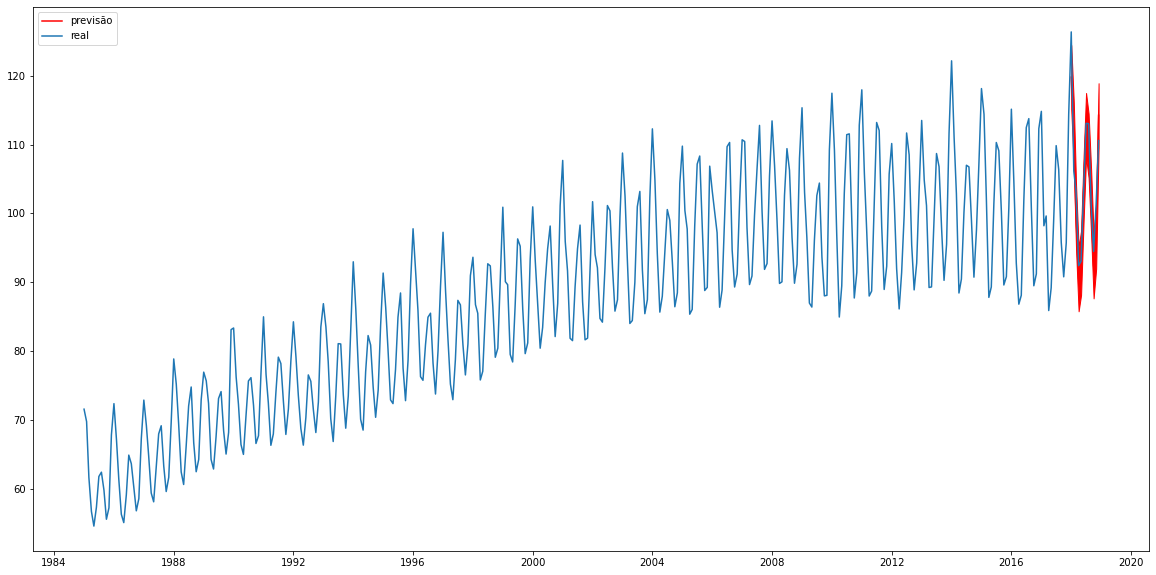

In [21]:
plt.figure(figsize=(20,10))
plt.plot(datas_previsao, predicao_media.values, color="red", label="previsão")
plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color="red")
plt.plot(datas, df.values, label="real")
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df[-12:].values, predicao_media.values)
print(mae)


2.7071204279475474


In [23]:
forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [24]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[0], intervalo_acima_f[0]

(115.34916554539014, 124.65958370869969)

In [25]:
forecast_medio[0]

120.00437462704491

In [26]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates = np.asarray(predicao_media.index)

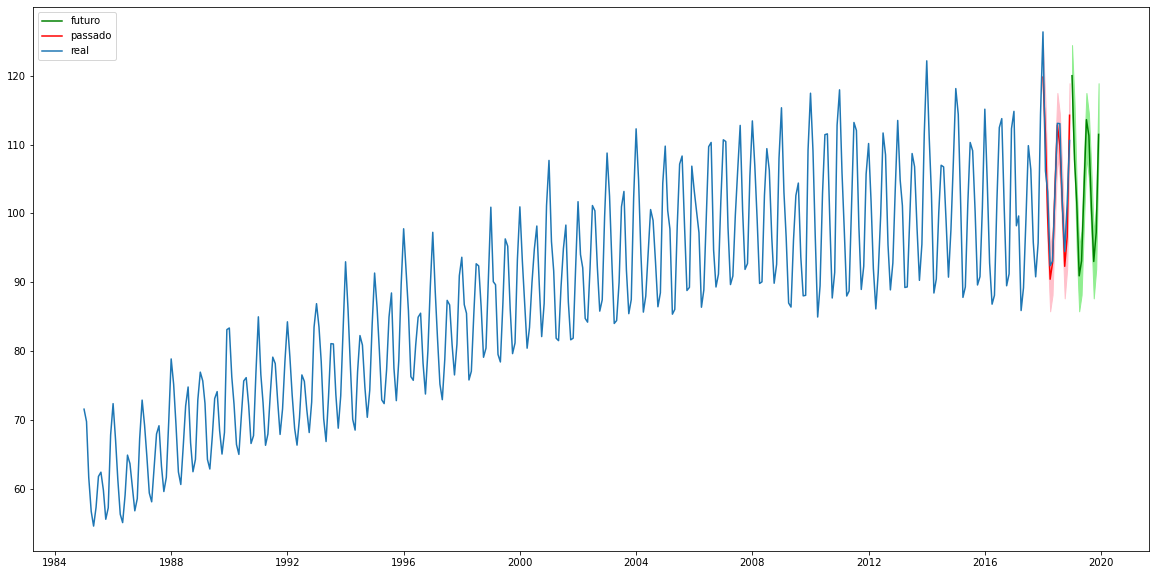

In [27]:
plt.figure(figsize=(20,10))
plt.plot(datas_forecast, forecast_medio.values, color="green", label="futuro")
plt.fill_between(datas_forecast, limite_abaixo, limite_acima, color="lightgreen")

plt.plot(datas_previsao, predicao_media.values, color="red", label="passado")
plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color="pink")

plt.plot(datas, df.values, label="real")
plt.legend(loc="upper left")
plt.show()